In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load in some of the SciKit Learn Preprocessing and Dimensionality Reduction Tools
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.decomposition import PCA

# Let's load in some key features from SciKit Learn where we can split the datasets up
# do the grid search, and construct a ML Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Let's load in some potential models (Decision Tree and SVC)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.svm import SVC

# Let's load in some metrics packages to assess the quality of our models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Basics of making a Deterministic ML Classifier Model

## 1.1) Load in dataset

In [68]:
data = pd.read_csv("/share/data/ESCI446/SARS/sars_supercell.txt",\
                   delimiter='\t',
                   on_bad_lines='skip')

In [69]:
data

,FILENAME,CAT,MLMIXR,ML CAPE,ML CIN,MLCL(MAGL),0-1SRH,0-6KT,STPC,500 T (C),500DIR,7-5 LR,0-3(KT),0-9(KT),0-3 KM SRH (M2/S2)
0,00042320.TXK,2,12.9,1702,-1,657,134,61.7,2.3,-14.0,250,6.5,32.8,76.6,166
1,00042001.PPF,2,13.5,2614,-50,1216,227,59.9,4.7,-12.9,234,7.5,39.7,73.5,244
2,00032900.FTW,2,13.1,2058,-42,1069,83,49.7,1.3,-15.2,245,8.0,21.9,87.1,126
3,00032304.SJT,2,11.9,1680,-119,896,119,61.1,1.1,-15.5,212,9.1,38.4,66.9,217
4,00031622.ATT,2,9.4,1019,-7,1566,12,45.8,0.0,-17.5,249,8.0,34.4,53.7,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,99082022.DIK,0,11.7,1445,-10,1669,21,33.6,0.1,-7.8,298,6.3,17.8,36.0,58
838,99081922.MLS,0,7.1,393,-105,3278,19,33.8,0.0,-10.0,244,8.6,22.0,37.3,120
839,99081800.RRT,0,11.4,1524,-26,847,90,49.2,1.1,-17.7,268,7.3,32.2,62.0,126
840,99081400.ALB,0,16.8,1843,-4,701,196,38.5,2.3,-6.3,249,5.8,29.9,48.4,252


## 1.2) Conduct Exploratory Data Analysis

Learn some things about your data!  This step is skipped here because we've done this elsewhere, and this notebook focuses on the steps to train a ML model.

## 1.3) Split the dataset into the predictors (x) and the predictands (y)

We don't need the filename or the category to do our prediction, so let's get rid of those columns.

In [70]:
x_values = data.drop(columns=['FILENAME','CAT'], axis=1) # Our Predictors (X)

## Create a binary label for cases when there was no tornado and when there was a tornado.
bin_transform = Binarizer(threshold=0.5) # Create a Binarizer object that will generate a 0 or 1 based upon the threshold.
y_values = bin_transform.transform(data['CAT'].to_numpy().reshape(-1,1)) # Convert the CAT data to 0s (NoTor) and 1s (Tor)
y_values = pd.DataFrame(y_values, columns=["TorCategory"]) # Put the Y values in a Dataframe and label the column "TorCategory"

## 1.4) Split the training and testing datasets

Let's split our dataset up into training and testing datasets.  We'll only be focusing on the training dataset.  Don't look at the testing dataset!  We don't want your knowledge of this to influence your decision making of how to construct your model.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.20)

## 1.5) Construct the ML Pipelines

Let's construct two ML Pipelines, one using a Decision Tree and the other using a Support Vector Classifier (SVC).  The first step will be to perform scaling of the dataset to try to make the data more easy to fit.

We're going to manually set two hyperparameters for these models.

In [72]:
model_svc = Pipeline(steps=[('scaling', StandardScaler()),\
                            ('svc', SVC(C=7.5))])

model_tree = Pipeline(steps=[('scaling', StandardScaler()), \
                             ('tree', DecisionTreeClassifier(max_depth=4))])


## 1.6) Train the model

Run the function .fit() on your ML Pipeline.

In [73]:
# Run the .fit() function to start the training of the ML Pipeline.
model_svc.fit(X_train, y_train)
model_tree.fit(X_train, y_train)

/opt/conda/envs/mvu-spring-2023/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaling', StandardScaler()),
                ('tree', DecisionTreeClassifier(max_depth=4))])

## 1.7) Visualize the Decision Tree

SciKit Learn allows us to look at the decision tree that we created using the command below:

In [74]:
feature_names = list(X_train.columns.to_numpy())
text_tree = export_text(model_tree['tree'], feature_names=feature_names)
print(text_tree)

|--- STPC <= -0.40
|   |--- 0-1SRH <= -0.81
|   |   |--- 0-3 KM SRH (M2/S2) <= -1.10
|   |   |   |--- ML CAPE <= -1.45
|   |   |   |   |--- class: 1
|   |   |   |--- ML CAPE >  -1.45
|   |   |   |   |--- class: 0
|   |   |--- 0-3 KM SRH (M2/S2) >  -1.10
|   |   |   |--- 500 T (C) <= -0.10
|   |   |   |   |--- class: 0
|   |   |   |--- 500 T (C) >  -0.10
|   |   |   |   |--- class: 0
|   |--- 0-1SRH >  -0.81
|   |   |--- 7-5 LR <= -1.04
|   |   |   |--- 500 T (C) <= 1.33
|   |   |   |   |--- class: 1
|   |   |   |--- 500 T (C) >  1.33
|   |   |   |   |--- class: 0
|   |   |--- 7-5 LR >  -1.04
|   |   |   |--- ML CAPE <= -0.57
|   |   |   |   |--- class: 0
|   |   |   |--- ML CAPE >  -0.57
|   |   |   |   |--- class: 0
|--- STPC >  -0.40
|   |--- 500DIR <= 0.35
|   |   |--- 500 T (C) <= -0.41
|   |   |   |--- 0-6KT <= 0.16
|   |   |   |   |--- class: 1
|   |   |   |--- 0-6KT >  0.16
|   |   |   |   |--- class: 0
|   |   |--- 500 T (C) >  -0.41
|   |   |   |--- 0-1SRH <= -0.20
|   |   |  

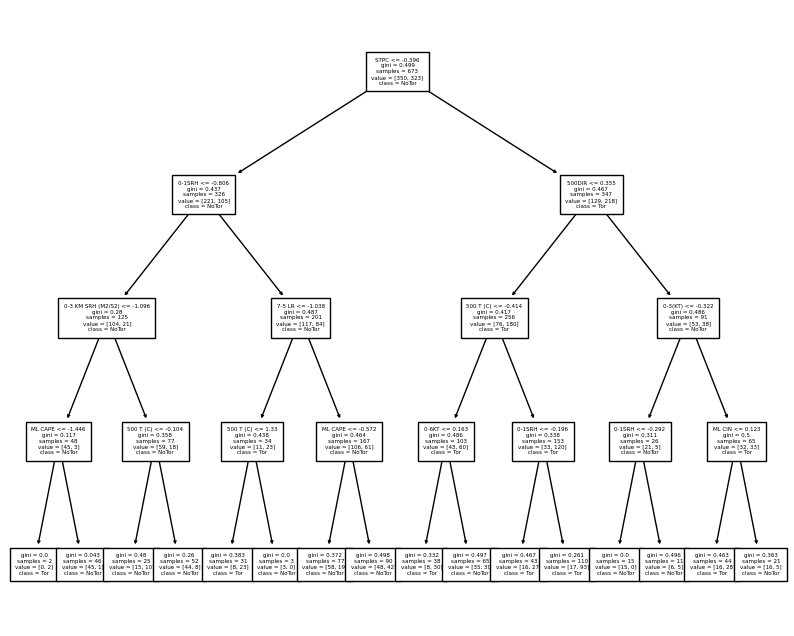

In [75]:
fig, ax = plt.subplots(figsize=(10,8))

plot_tree(model_tree['tree'], feature_names=X_train.columns,  
                   class_names=['NoTor', 'Tor'],
                   ax=ax, fontsize=4)

plt.savefig('decision_tree.png', dpi=300)

In [76]:
y_predict_svc = model.predict(X_test)
y_predict_tree = model_tree.predict(X_test)

## 1.8) Evaluate the two models (SVC and Decision Tree)

Let's evaluate these two models using a confusion matrix.

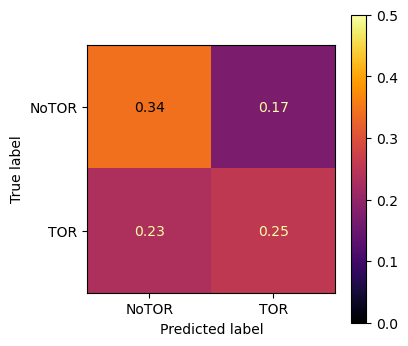

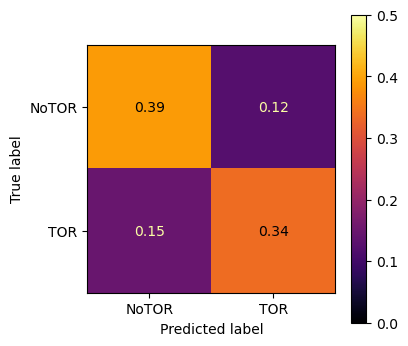

(0.33727810650887574,
 0.1242603550295858,
 0.14792899408284024,
 0.3905325443786982)

In [77]:
def show_confusion_matrix(test, predict, normalize='all', labels=['NoTOR','TOR'],\
                          figsize=(4,4), clim=(0,.5)):

    # Make a confusion matrix for the SVC model
    cm = confusion_matrix(test, predict, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, \
                                  display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(cmap='inferno', ax=ax)
    disp.ax_.get_images()[0].set_clim(clim[0], clim[1]) # Sets the limits of the colorbar between 0 and .5
    plt.show()
    
    d, b, c, a = cm.flatten()
    return a, b, c, d
    
show_confusion_matrix(y_test, y_predict_tree)
show_confusion_matrix(y_test, y_predict_svc)

# 2. Performing the Grid Search

The above workflow has some issues:

1. We are tempted to start using the performance of the test dataset to help us select the hyperparameters.  If we do this, we're gonna see knowledge about the test dataset leak into our training process.  This is akin to cheating, in a way.
2. We are conducting a trial and error process for choosing the hyperparameters.  We'd do much better by searching for the best hyperparameters instead.

We can solve this by doing a Grid Search with Cross Validation, which is used in the GridSearchCV object in the SciKit Learn.  Let's construct a new ML Pipeline using the StandardScaler, a data compression method called PCA, and the DecisionTreeClassifier:

In [78]:
# Define the parameter grid
model_tree = Pipeline([('scaling', StandardScaler()), 
                       ('pca', PCA()), \
                       ('tree', DecisionTreeClassifier())])

## 2.1) Setting the hyperparameter search space

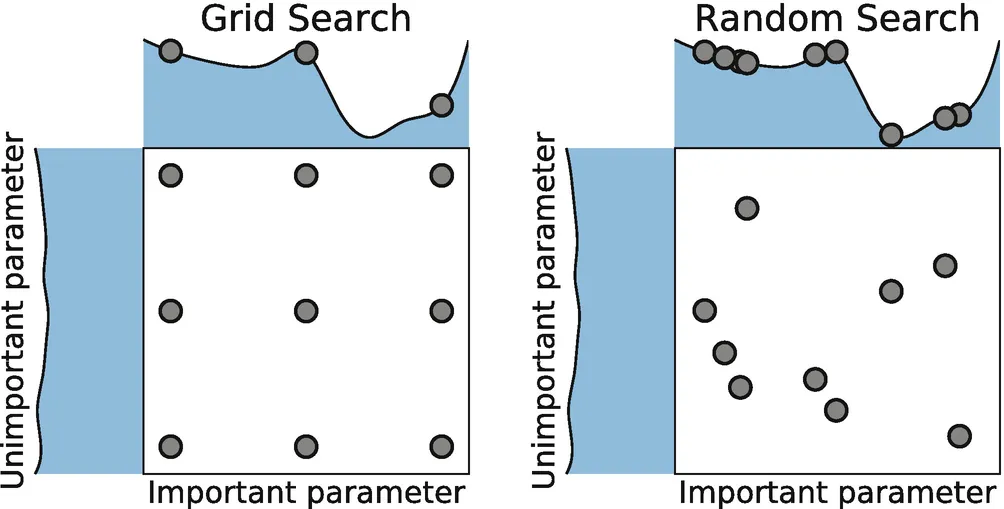

Our grid search allows us to explore different combinations of hyperparameters.  We can also search randomly too, which is something you can look up on your own.  This will allow us to figure out if there are any important hyperparameters, in that they are more important for our problem.

For now, let's vary the max depth for our tree.  We can have 2, 4, 7, 12, or 16 branches for our tree.  Let's also change the number of components left behind by the PCA method.  Principal Component Analysis (PCA) attempts to take a dataset and split up into independent components or vectors.  Each successive vector or component describes more and more nuances of the dataset.  Often this extra detail can hurt our model development, so we try to retain only a certain number of components.

In [79]:
parameter_grid = [{'tree__max_depth': [2, 4, 7, 12, 16], \
                   'pca__n_components': [1,2,3,4,5,6,7,8,9,10,11]}]

## 2.2) Set up the GridSearchCV

So, we're going to set up the Grid Search.  We're going to pass the Pipeline object `model_tree` we constructed in the cell before this and the parameter grid to the object `parameter_grid`.  

There is another step we need to do, and that is perform Cross-Validation.  What this means is that we use a resampling method that uses different portions of the data to evaluate and fit a model multiple times.  This process shuffles our training data and "folds" it $k$ times.  For example, if $k=5$ our training dataset gets split into 5 parts.  Then, when we call `fit()`, our model gets fit five times.  Each time, it uses 1 part as a "validation" dataset and the other 4 as training data.  This prevents us from overfitting our model too much to the training data.

With each model that gets fit, it is scored using some kind of metric against the "validation" data.  Then, the average of the scores is taken to identify how well the model performs.

Scikit Learn offers a wide variety of metrics for classification and regression problems.  Here is the website to see which scores exist: https://scikit-learn.org/stable/modules/model_evaluation.html.  Higher return values are better than lower ones.

In [80]:
k=5
classifier = GridSearchCV(estimator=model_tree, param_grid=parameter_grid, \
                          cv=k, scoring='accuracy')

## 2.3) Fit the model with our training data

In [81]:
classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', StandardScaler()),
                                       ('pca', PCA()),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid=[{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                11],
                          'tree__max_depth': [2, 4, 7, 12, 16]}],
             scoring='accuracy')

## 2.4) Find out the best model and parameters.

In [82]:
print(classifier.best_estimator_)
print(classifier.best_params_)

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=5)),
                ('tree', DecisionTreeClassifier(max_depth=2))])
{'pca__n_components': 5, 'tree__max_depth': 2}


## 2.5) Test the model using our test dataset (the one we haven't used for any of the fit() steps)

In [83]:
y_predict = classifier.predict(X_test)

## 2.6) Show the confusion matrix for your model

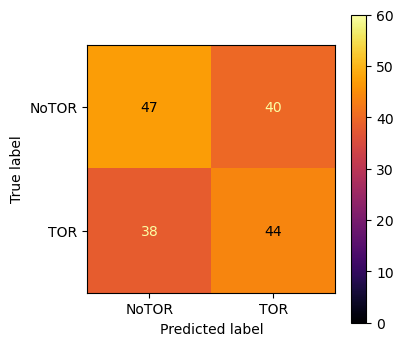

In [84]:
a, b, c, d = show_confusion_matrix(y_test, y_predict, normalize=None, clim=(0,60))

In [85]:
a, b, c, d

(44, 40, 38, 47)

# 3. Basics of making an Ensemble ML Classifier Model

In [140]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
model_randomforest = Pipeline([('scaling', StandardScaler()), 
                               ('pca', PCA()), \
                               ('rf', RandomForestClassifier())])

parameter_grid = [{'rf__max_depth': [2, 4, 7], \
                   'rf__n_estimators': [100],\
                   'pca__n_components': [4,5,6,7]}]

k=10
classifier = GridSearchCV(estimator=model_randomforest, param_grid=parameter_grid, \
                          cv=k, scoring='accuracy')

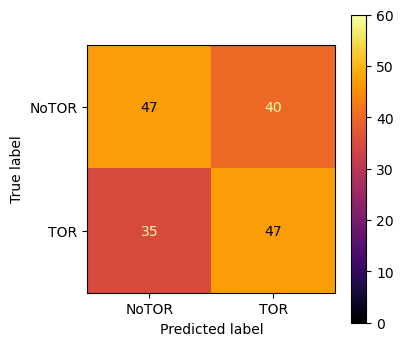

In [141]:
classifier.fit(X_train, y_train.to_numpy().squeeze())
y_predict = classifier.predict(X_test)
a, b, c, d = show_confusion_matrix(y_test, y_predict, normalize=None, clim=(0,60))

In [142]:
y_predict_prob = classifier.predict_proba(X_test)

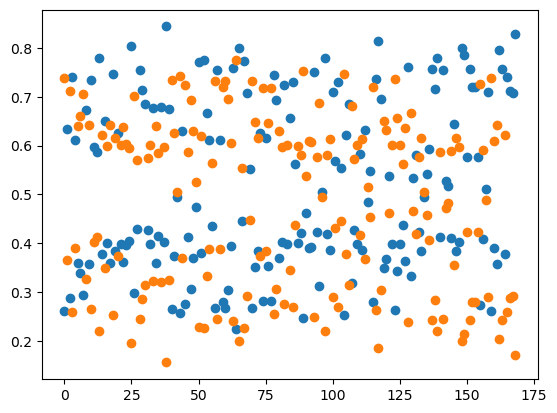

In [143]:
plt.plot(y_predict_prob, 'o')


In [144]:
print(classifier.best_estimator_)
print(classifier.best_params_)

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=4)),
                ('rf', RandomForestClassifier(max_depth=4, n_estimators=1000))])
{'pca__n_components': 4, 'rf__max_depth': 4, 'rf__n_estimators': 1000}


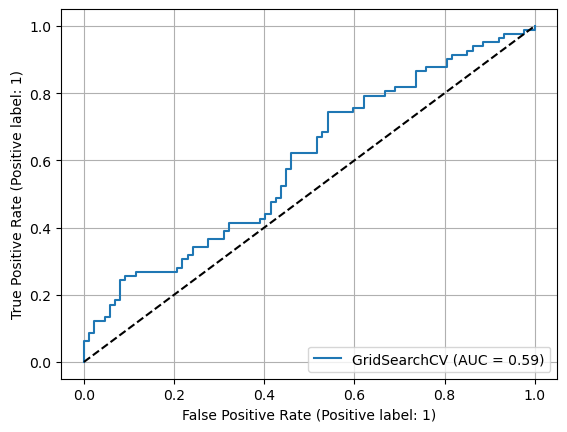

In [145]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(classifier, X_test, y_test, pos_label=1)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.grid()